In [1]:
!pip uninstall scikit-learn
!pip install scikit-learn==1.1.3


Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/scikit_learn-1.6.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.11/dist-packages/sklearn/*
Proceed (Y/n)? Y
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 53.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip uninstall -y xgboost
!pip install xgboost==1.7.5


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 2.0 MB/s eta 0:00:00


In [4]:
DATADIR = '/content/drive/MyDrive/fan/id_00'

In [5]:
!pip install librosa numpy pandas seaborn matplotlib lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=510188a15452635a4a6ccfb720f73fc6028ed021a2a1bf4787d51d8ecf6778e4
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [6]:
feature_names = [
    'mean', 'median', 'variance', 'std_dev', 'skewness', 'kurt', 'zero_cross_rate',
    'num_waves', 'wave_duration', 'inst_freq', 'mobility', 'activity', 'complexity', 'k_complex', 'energy',
    'mean_freq', 'median_freq', 'variance_freq', 'std_dev_freq', 'skewness_freq', 'kurt_freq',
    'delta', 'theta', 'alpha', 'beta', 'gamma', 'sigma', 'zero_a', 'b_a'
]
assert len(feature_names) == 29, "Number of feature names does not match"

In [9]:
import os
import librosa
import numpy as np
from scipy.stats import skew, kurtosis
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

DATADIR = '/content/drive/MyDrive/fan/id_00'
CATEGORIES = ['abnormal', 'normal']

def augment_audio(audio):
    noise = np.random.normal(0, 0.005, len(audio))
    audio_noise = audio + noise

    try:
        audio_stretch = librosa.effects.time_stretch(audio, rate=0.8)
    except Exception as e:
        print("Time stretch error:", e)
        audio_stretch = audio

    try:
        audio_pitch = librosa.effects.pitch_shift(audio, sr=22050, n_steps=2)
    except Exception as e:
        print("Pitch shift error:", e)
        audio_pitch = audio

    return [audio_noise, audio_stretch, audio_pitch]

def extract_features_from_audio_advanced(audio, sr):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    mfccs_skew = skew(mfccs, axis=1)
    mfccs_kurtosis = kurtosis(mfccs, axis=1)

    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    delta_mfccs_mean = np.mean(delta_mfccs, axis=1)
    delta2_mfccs_mean = np.mean(delta2_mfccs, axis=1)

    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))
    spec_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr), axis=1)

    zcr = np.mean(librosa.feature.zero_crossing_rate(audio))
    zcr_std = np.std(librosa.feature.zero_crossing_rate(audio))

    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr), axis=1)

    y_harmonic = librosa.effects.harmonic(audio)
    tonnetz = np.mean(librosa.feature.tonnetz(y=y_harmonic, sr=sr), axis=1)

    rmse = np.mean(librosa.feature.rms(y=audio))
    flatness = np.mean(librosa.feature.spectral_flatness(y=audio))
    ste = np.mean(audio ** 2)

    features = np.hstack([
        mfccs_mean,
        mfccs_std,
        mfccs_skew,
        mfccs_kurtosis,
        delta_mfccs_mean,
        delta2_mfccs_mean,
        spec_centroid,
        spec_rolloff,
        spec_contrast,
        zcr,
        zcr_std,
        chroma,
        tonnetz,
        rmse,
        flatness,
        ste
    ])
    return features

def extract_features_and_labels_with_augmentation(data_dir):
    features_list = []
    labels_list = []
    for category in CATEGORIES:
        category_path = os.path.join(data_dir, category)
        print(f"Looking in folder: {category_path}")
        print("Files found:", os.listdir(category_path))
        label = 1 if category == 'abnormal' else 0
        for file in os.listdir(category_path):
            if file.lower().endswith(('.mp3', '.wav')):
                print(f"Processing file: {file}")
                file_path = os.path.join(category_path, file)
                try:
                    audio, sr = librosa.load(file_path, sr=22050)
                    features_list.append(extract_features_from_audio_advanced(audio, sr))
                    labels_list.append(label)

                    if label == 0:
                        augmentations = augment_audio(audio) * 2
                    else:
                        augmentations = augment_audio(audio)

                    for aug_audio in augmentations:
                        features_list.append(extract_features_from_audio_advanced(aug_audio, sr))
                        labels_list.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    print("Number of files processed:", len(features_list))
    return np.array(features_list), np.array(labels_list)



X_aug, y_aug = extract_features_and_labels_with_augmentation(DATADIR)
X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y_aug, test_size=0.2, random_state=42, stratify=y_aug
)
rus = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)
X_test_balanced, y_test_balanced = rus.fit_resample(X_test, y_test)

print("Augmented Features shape:", X_aug.shape)
print("Augmented Labels shape:", y_aug.shape)
print("Balanced Training Set Distribution:", dict(zip(*np.unique(y_train_balanced, return_counts=True))))
print("Balanced Test Set Distribution:", dict(zip(*np.unique(y_test_balanced, return_counts=True))))

Looking in folder: /content/drive/MyDrive/fan/id_00/abnormal
Files found: ['Coffee room 01_fall_video (1).mp3', 'Coffee room 01_fall_video (10).mp3', 'Coffee room 01_fall_video (11).mp3', 'Coffee room 01_fall_video (12).mp3', 'Coffee room 01_fall_video (13).mp3', 'Coffee room 01_fall_video (14).mp3', 'Coffee room 01_fall_video (15).mp3', 'Coffee room 01_fall_video (16).mp3', 'Coffee room 01_fall_video (17).mp3', 'Coffee room 01_fall_video (18).mp3', 'Coffee room 01_fall_video (19).mp3', 'Coffee room 01_fall_video (2).mp3', 'Coffee room 01_fall_video (20).mp3', 'Coffee room 01_fall_video (21).mp3', 'Coffee room 01_fall_video (22).mp3', 'Coffee room 01_fall_video (23).mp3', 'Coffee room 01_fall_video (24).mp3', 'Coffee room 01_fall_video (25).mp3', 'Coffee room 01_fall_video (26).mp3', 'Coffee room 01_fall_video (27).mp3', 'Coffee room 01_fall_video (28).mp3', 'Coffee room 01_fall_video (29).mp3', 'Coffee room 01_fall_video (3).mp3', 'Coffee room 01_fall_video (30).mp3', 'Coffee room 01_

In [29]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=cv, scoring='accuracy')

print("Cross-validation scores:", scores)
print("Mean cross-validation accuracy:", scores.mean())


Cross-validation scores: [0.94074074 0.94074074 0.92537313 0.94776119 0.93283582]
Mean cross-validation accuracy: 0.9374903261470425


In [8]:
!pip uninstall imbalanced-learn
!pip install imbalanced-learn==0.12.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 6.0 MB/s eta 0:00:00


In [27]:
unique_train, counts_train = np.unique(y_aug, return_counts=True)
unique_test, counts_test = np.unique(y_aug, return_counts=True)
print("Training set distribution:", dict(zip(unique_train, counts_train)))
print("Test set distribution:", dict(zip(unique_test, counts_test)))


Training set distribution: {0: 420, 1: 520}
Test set distribution: {0: 420, 1: 520}


In [26]:
np.save('/content/drive/MyDrive/fan/X_aug.npy', X_aug)
np.save('/content/drive/MyDrive/fan/y_aug.npy', y_aug)


In [25]:
import joblib

joblib.dump(best_model, '/content/drive/MyDrive/fan/best_xgb_model.pkl')


['/content/drive/MyDrive/fan/best_xgb_model.pkl']

In [24]:
results = {
    'Best Parameters': random_search.best_params_,
    'Best CV Accuracy': random_search.best_score_,
    'Test Accuracy': test_accuracy,
    'Classification Report': classification_report(y_test, y_pred)
}

import json
with open('/content/drive/MyDrive/fan/experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)


In [13]:
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

class SklearnXGBClassifier(XGBClassifier, BaseEstimator, ClassifierMixin):
    def __sklearn_tags__(self):
        return {"binary_only": True}

xgb_model = SklearnXGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                 scale_pos_weight=scale_pos_weight)


In [15]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore", message="`use_label_encoder` is deprecated in 1.7.0.")

X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

negative_count = np.sum(y_train == 0)
positive_count = np.sum(y_train == 1)
scale_pos_weight = negative_count / positive_count
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

param_grid_expanded = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    tree_method='hist',  # Use CPU histogram
    verbosity=1
)


random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid_expanded,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    n_jobs=1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

print("Best Parameters (Randomized):", random_search.best_params_)
print("Best CV Accuracy (Randomized):", random_search.best_score_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Calculated scale_pos_weight: 0.84
Best Parameters (Randomized): {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best CV Accuracy (Randomized): 0.9347549668874173
Test Set Accuracy: 0.9574468085106383

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95        76
           1       0.98      0.95      0.96       112

    accuracy                           0.96       188
   macro avg       0.95      0.96      0.96       188
weighted avg       0.96      0.96      0.96       188



In [16]:
label = 1 if CATEGORIES == 'abnormal' else 0


In [17]:
sample_audio = X_test_scaled[0].reshape(1, -1)
predicted_prob = best_model.predict_proba(sample_audio)
print("Predicted probabilities:", predicted_prob)


Predicted probabilities: [[0.9942593  0.00574072]]


In [18]:
from imblearn.over_sampling import SMOTE
print("SMOTE imported successfully!")


SMOTE imported successfully!


In [19]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Set Accuracy: 0.9574468085106383

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95        76
           1       0.98      0.95      0.96       112

    accuracy                           0.96       188
   macro avg       0.95      0.96      0.96       188
weighted avg       0.96      0.96      0.96       188



In [20]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


XGBoost Accuracy: 0.9680851063829787


In [21]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

best_xgb = random_search.best_estimator_
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
svc_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('xgb', best_xgb), ('rf', rf_clf), ('svc', svc_clf)],
    voting='soft'
)

voting_clf.fit(X_train_scaled, y_train)
y_pred_ensemble = voting_clf.predict(X_test_scaled)

from sklearn.metrics import accuracy_score, classification_report
print("Ensemble Test Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("\nEnsemble Classification Report:\n", classification_report(y_test, y_pred_ensemble))


Ensemble Test Accuracy: 0.9680851063829787

Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        76
           1       0.98      0.96      0.97       112

    accuracy                           0.97       188
   macro avg       0.97      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188



In [30]:
import joblib
joblib.dump(voting_clf, 'ensemble_model.pkl')

['ensemble_model.pkl']

PermutationExplainer explainer: 189it [07:59,  2.56s/it]


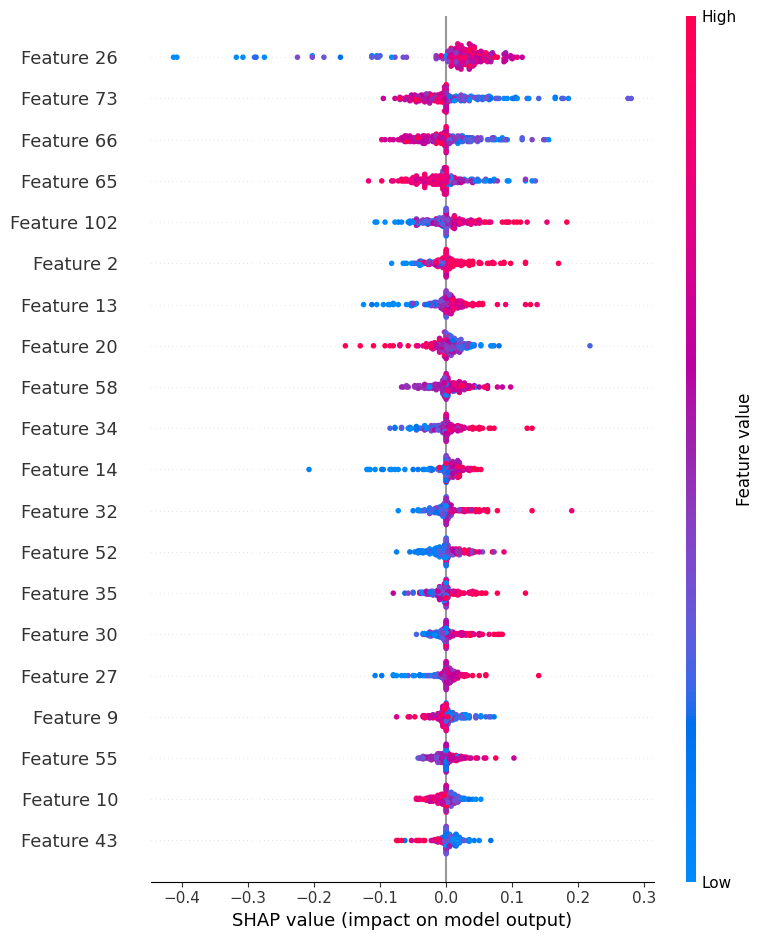

In [33]:
import shap
explainer = shap.Explainer(voting_clf.predict, X_train_scaled)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled)


In [32]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.2/540.2 kB 16.8 MB/s eta 0:00:00


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        76
           1       1.00      0.95      0.97       112

    accuracy                           0.97       188
   macro avg       0.96      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188

Confusion Matrix:
 [[ 76   0]
 [  6 106]]


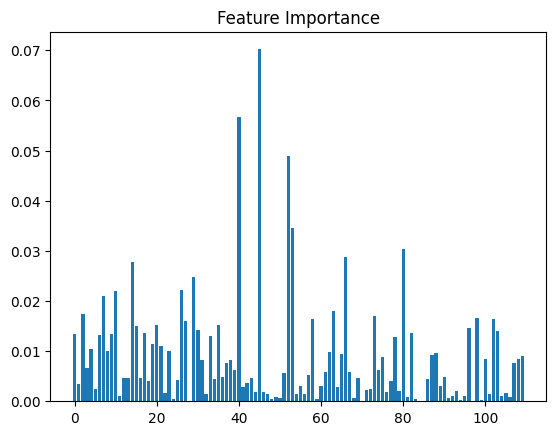

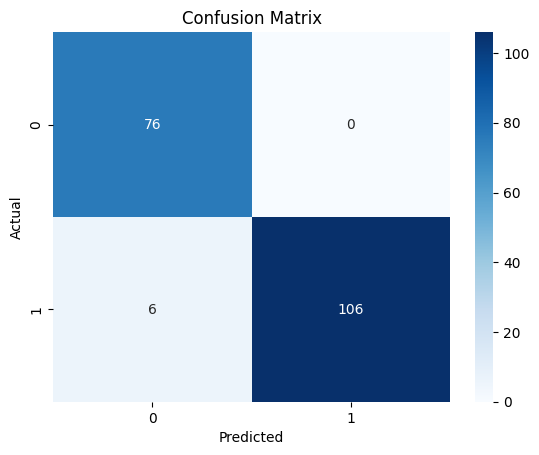

In [23]:
import matplotlib.pyplot as plt

plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
plt.title("Feature Importance")
plt.show()

import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


<ipython-input-36-f54d02fef7d3>:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Class")


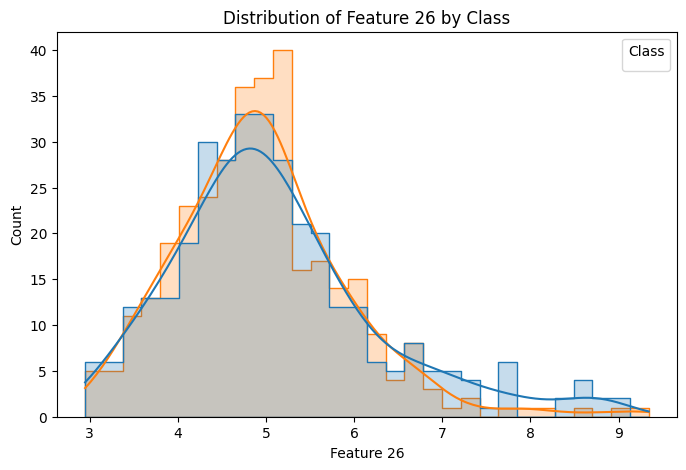

<ipython-input-36-f54d02fef7d3>:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Class")


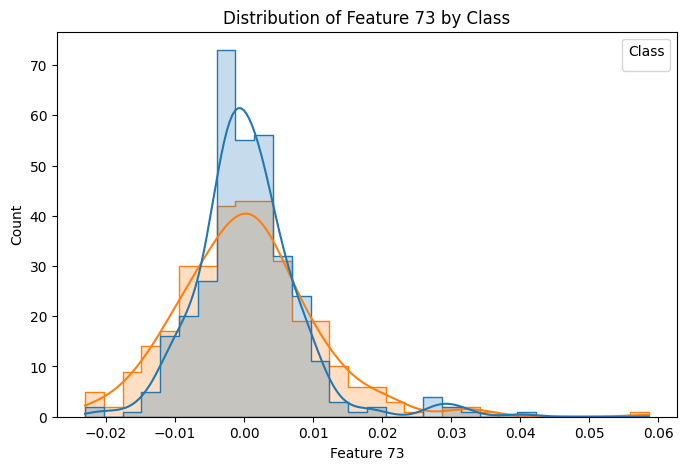

<ipython-input-36-f54d02fef7d3>:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Class")


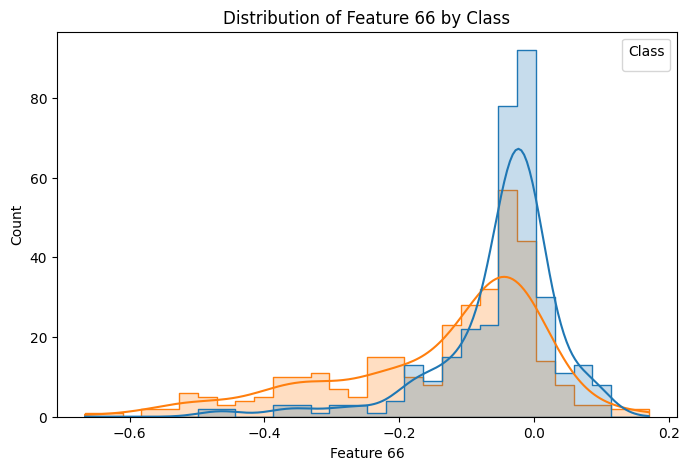

<ipython-input-36-f54d02fef7d3>:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Class")


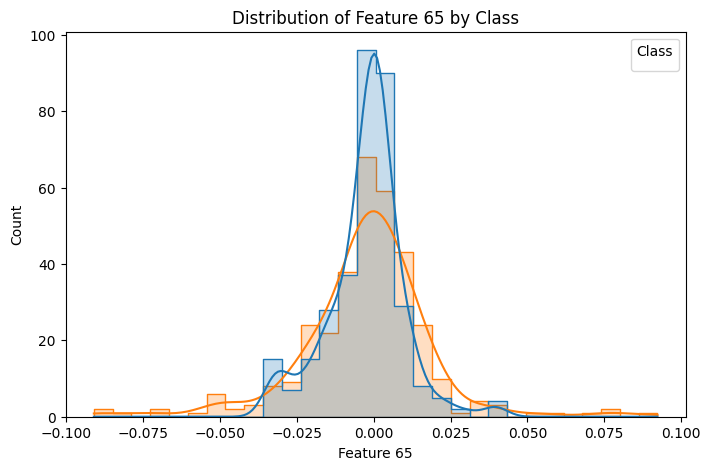

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

feature_indices = {
    "Feature 26": 25,
    "Feature 73": 72,
    "Feature 66": 65,
    "Feature 65": 64
}

class_labels = np.where(y_train_balanced == 1, "Fall", "Non-fall")

for feature_name, idx in feature_indices.items():
    plt.figure(figsize=(8, 5))
    data = {
        feature_name: X_train_balanced[:, idx],
        "Class": class_labels
    }
    sns.histplot(data=data, x=feature_name, hue="Class", bins=30, kde=True, element="step")
    plt.title(f"Distribution of {feature_name} by Class")
    plt.xlabel(feature_name)
    plt.ylabel("Count")
    plt.legend(title="Class")
    plt.show()


<ipython-input-38-654798bed5d2>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Class")


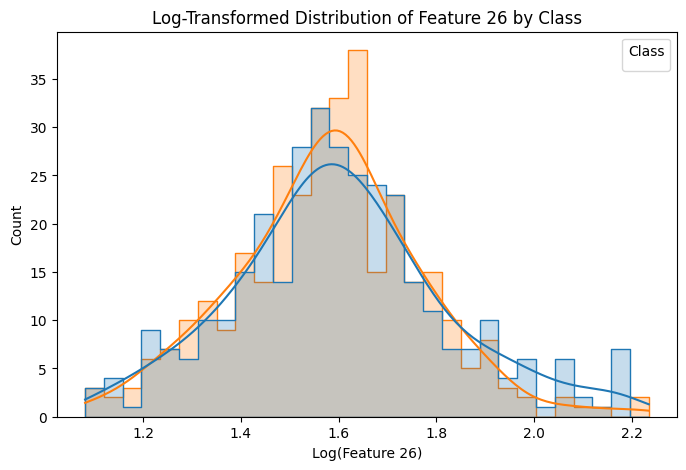

In [38]:
feature = X_train_balanced[:, feature_indices["Feature 26"]]
log_feature = np.log(feature + 1e-6)

plt.figure(figsize=(8, 5))
sns.histplot(x=log_feature, hue=class_labels, bins=30, kde=True, element="step")
plt.title("Log-Transformed Distribution of Feature 26 by Class")
plt.xlabel("Log(Feature 26)")
plt.ylabel("Count")
plt.legend(title="Class")
plt.show()


In [ ]:
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
